In [55]:
import torch
import torchvision
from torch import nn, optim
from torch.utils.data import DataLoader, SubsetRandomSampler
import matplotlib.pyplot as plt
import math
import time
import numpy as np
import cv2

In [56]:
mnist = torchvision.datasets.MNIST('data', train=True, transform=torchvision.transforms.ToTensor(), download=True)
dataloader = DataLoader(mnist, batch_size=16, shuffle=True)

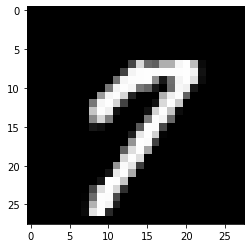

In [57]:
images, labels = next(iter(dataloader))

plt.imshow(images[0, 0], cmap='Greys_r')
plt.show()

In [89]:
class ResidualBlock(nn.Module):
    def __init__(self, hidden_size, kernel_size=3):
        super(ResidualBlock, self).__init__()

        self.residual = nn.Sequential(
            nn.Conv2d(hidden_size, hidden_size//2, kernel_size=1, bias=False), 
            nn.BatchNorm2d(hidden_size//2),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden_size//2, hidden_size//2, kernel_size=kernel_size, padding=kernel_size//2, bias=False), 
            nn.BatchNorm2d(hidden_size//2), 
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden_size//2, hidden_size, kernel_size=1, bias=False), 
            nn.BatchNorm2d(hidden_size),
        )

    def forward(self, x):
        return x + self.residual(x)

class ShuffleCNN(nn.Module):
    def __init__(self, num_classes, hidden_size=64):
        super(ShuffleCNN, self).__init__()
        
        self.cnn = nn.Sequential(          
            nn.Conv2d(1, hidden_size, kernel_size=7, padding=3, bias=False), nn.BatchNorm2d(hidden_size), nn.ReLU(inplace=True),
            nn.Conv2d(hidden_size, hidden_size, kernel_size=7, padding=3, bias=False), nn.BatchNorm2d(hidden_size), nn.ReLU(inplace=True),
            ResidualBlock(hidden_size),
            ResidualBlock(hidden_size),
            nn.Conv2d(hidden_size, hidden_size, kernel_size=7, padding=3, bias=False), nn.BatchNorm2d(hidden_size), nn.ReLU(inplace=True),
            nn.Conv2d(hidden_size, hidden_size, kernel_size=7, padding=3, bias=False), nn.BatchNorm2d(hidden_size), nn.ReLU(inplace=True),
            nn.Conv2d(hidden_size, 256, kernel_size=1),
        )
        
    def forward(self, x):
        x = self.cnn(x)
        return x

In [92]:
shuffleCNN = ShuffleCNN(num_classes=10, hidden_size=32)
shuffleCNN.cuda()

ShuffleCNN(
  (cnn): Sequential(
    (0): Conv2d(1, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ResidualBlock(
      (residual): Sequential(
        (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
        (6): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (7): Ba

In [93]:
# sample
def sample(num_samples = 5, temperature = 1, label=None, pixels_per_round = 8):   
    sample = torch.zeros(num_samples, 1, 28, 28).cuda()
    
    pixel_positions = [(x, y) for x in range(28) for y in range(28)]  
    np.random.shuffle(pixel_positions)
    
    shuffleCNN.eval()
    for r in range(math.ceil(len(pixel_positions) / pixels_per_round)):
        pred = shuffleCNN(sample)       
        for x, y in pixel_positions[:pixels_per_round]:
            pixel = (pred[:, :, x, y]/temperature).softmax(dim=-1)
            sample[:, :, x, y] = torch.multinomial(pixel, 1).float() / 255. 
    
        pixel_positions = pixel_positions[pixels_per_round:]
        
    plt.imshow(torch.cat([s for s in sample], dim=-1)[0].cpu() * 2, cmap='Greys_r')
    plt.show()

Epoch 1 (500/3750) - loss 1.7526528372764587 (19.0s)
Epoch 1 (1000/3750) - loss 1.3113023884892463 (22.6s)
Epoch 1 (1500/3750) - loss 1.1573859421014785 (24.8s)
Epoch 1 (2000/3750) - loss 1.0686329255104066 (25.0s)
Epoch 1 (2500/3750) - loss 1.010499144911766 (25.0s)
Epoch 1 (3000/3750) - loss 0.9695505572954813 (25.0s)
Epoch 1 (3500/3750) - loss 0.9388081064053945 (39.7s)
Epoch 1 (3750/3750) - loss 0.9246129977703095 (15.6s)


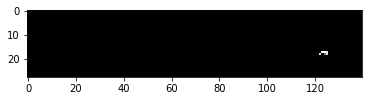

Epoch 2 (500/3750) - loss 0.7382531563043594 (27.1s)
Epoch 2 (1000/3750) - loss 0.7325165974199772 (30.8s)
Epoch 2 (1500/3750) - loss 0.7246412654717763 (25.8s)
Epoch 2 (2000/3750) - loss 0.7221460039168597 (25.1s)
Epoch 2 (2500/3750) - loss 0.7175570698738098 (25.5s)
Epoch 2 (3000/3750) - loss 0.7158687155147394 (30.3s)
Epoch 2 (3500/3750) - loss 0.7118170183471271 (36.7s)
Epoch 2 (3750/3750) - loss 0.7106251151959101 (25.8s)


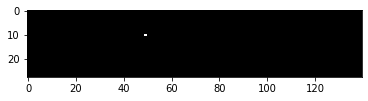

Epoch 3 (500/3750) - loss 0.6760479708313942 (42.6s)
Epoch 3 (1000/3750) - loss 0.6713933098912239 (39.7s)
Epoch 3 (1500/3750) - loss 0.668712412973245 (43.1s)


In [ ]:
epochs = 10
print_every = 500

optimizer = optim.Adam(shuffleCNN.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

for e in range(1, epochs+1):
    total_loss = 0
    shuffleCNN.train()
    start_time = time.time()
    for batch, (images, labels) in enumerate(dataloader):
        images, labels = images.cuda(), labels.cuda()
        target = (images[:,0] * 255).long()
        
        random_threshold = np.random.uniform(0.01, 1)
        mask = (torch.rand_like(images) > random_threshold).float()
        
        masked_images = images * mask
        
        pred = shuffleCNN(masked_images)       
        loss = criterion(pred, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        if (batch+1) % print_every == 0 or (batch+1) == len(dataloader):
            elapsed_time = time.time() - start_time
            start_time = time.time()
            print(f"Epoch {e} ({batch+1}/{len(dataloader)}) - loss {total_loss/(batch+1)} ({elapsed_time:.1f}s)")
    
    sample(num_samples = 5) # sample after every epoch
    # scheduler.step()

In [ ]:
sample(5, temperature=1.2)